In [17]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../VT_SNN/")

In [18]:
import torch
import numpy as np
import slayerSNN as snn
from pathlib import Path
import logging
from snn_models.baseline_snn import SlayerMLP
from snn_models.multimodal_snn import EncoderVis
from torch.utils.data import DataLoader
from dataset import ViTacDataset, ViTacMMDataset, ViTacVisDataset

In [19]:
fname='../../aux_rests/vision_32_old_loss_with_outlier'

In [20]:
class FLAGS():
    def __init__(self):
        self.data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN_new/'
        self.batch_size = 8
        self.sample_file = 2
        self.lr = 0.001
        self.epochs = 500
        self.output_size = 20
        self.theta = 10
        self.tauRho = 1
        self.tsample= 325
        self.tsr_stop = 325
        self.sc_true = 150
        self.sc_false = 5
        self.hidden_size = 32
args = FLAGS()

In [21]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": args.theta, # activation threshold
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": args.tsample, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 325,
            },
            "tgtSpikeCount": {True: args.sc_true, False: args.sc_false},
        }
    },
}

In [22]:
output_size = args.output_size # 20

train_dataset = ViTacVisDataset(
    path=args.data_dir, sample_file=f"train_80_20_{args.sample_file}.txt", output_size=args.output_size
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4
)
test_dataset = ViTacVisDataset(
    path=args.data_dir, sample_file=f"test_80_20_{args.sample_file}.txt", output_size=args.output_size
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)

In [23]:
len(train_dataset)

240

In [24]:
a,b,c = test_dataset[0]

In [25]:
a.shape, b.shape, c

(torch.Size([2, 63, 50, 325]), torch.Size([20, 1, 1, 1]), 0)

In [26]:
torch.unique(a)

tensor([0., 1.])

In [27]:
device = torch.device("cuda:0")
net = SlayerMLP(params, (50, 63, 2), args.hidden_size, args.output_size).to(device)

error = snn.loss(params).to(device)
optimizer = torch.optim.RMSprop(
    net.parameters(), lr=args.lr, weight_decay=0.5
)

In [28]:
net

SlayerMLP(
  (slayer): spikeLayer()
  (fc1): _denseLayer(2, 32, kernel_size=(63, 50, 1), stride=(1, 1, 1), bias=False)
  (fc2): _denseLayer(32, 20, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
)

In [29]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(1, args.epochs+1):
    tr_correct = 0
    btr_loss = 0
    net.train()
    for i, (vis, target, label) in enumerate(train_loader):
        vis = vis.to(device)
        target = target.to(device)
        output = net.forward( vis)
        tr_correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        loss = error.numSpikes(output, target)
        btr_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Evaluate
    te_correct = 0
    bte_loss = 0
    net.eval()
    with torch.no_grad():
        for i, (vis, target, label) in enumerate(test_loader):
            vis = vis.to(device)
            target = target.to(device)
            output = net.forward( vis)
            te_correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            loss = error.numSpikes(output, target)
            bte_loss += loss.item()

    if epoch%10 == 0:
        print('Epoch:', epoch)    
        print('Accs (train, test):', tr_correct/len(train_dataset), te_correct/len(test_dataset))
        print('Loss (train, test):', btr_loss/len(train_dataset), bte_loss/len(test_dataset))
    
    train_loss.append( btr_loss/len(train_dataset) )
    test_loss.append( bte_loss/len(test_dataset) )
    train_acc.append( tr_correct/len(train_dataset) )
    test_acc.append( te_correct/len(test_dataset) )

Epoch: 10
Accs (train, test): 0.5458333333333333 0.45
Loss (train, test): 21.346886316935223 24.62359224955241
Epoch: 20
Accs (train, test): 0.8375 0.5
Loss (train, test): 12.473327795664469 20.796539942423504
Epoch: 30
Accs (train, test): 0.9416666666666667 0.6166666666666667
Loss (train, test): 8.090737851460775 20.57666842142741
Epoch: 40
Accs (train, test): 0.9958333333333333 0.6833333333333333
Loss (train, test): 4.09125018119812 19.348000971476235
Epoch: 50
Accs (train, test): 0.9875 0.6166666666666667
Loss (train, test): 3.5271411915620168 19.5925651550293
Epoch: 60
Accs (train, test): 0.9916666666666667 0.5666666666666667
Loss (train, test): 2.173358968893687 18.534129587809243
Epoch: 70
Accs (train, test): 1.0 0.6833333333333333
Loss (train, test): 1.3222179661194484 18.36630833943685
Epoch: 80
Accs (train, test): 0.9958333333333333 0.7
Loss (train, test): 0.8357691784699758 18.692000834147134
Epoch: 90
Accs (train, test): 1.0 0.7833333333333333
Loss (train, test): 0.533967951

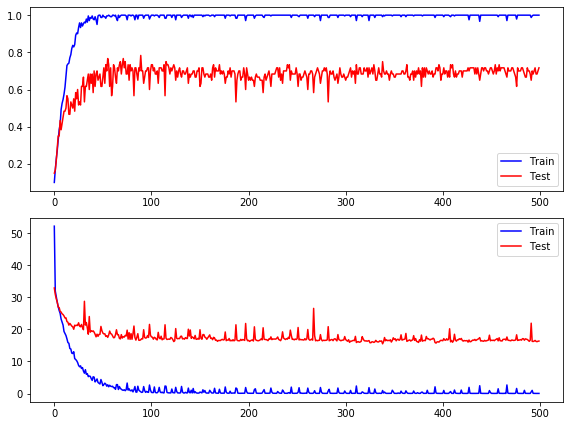

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,figsize=(8,6))
ax[0].plot(train_acc, 'b')
ax[0].plot(test_acc, 'r')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_loss, 'b')
ax[1].plot(test_loss, 'r')
ax[1].legend(['Train', 'Test'])
plt.tight_layout(True)
plt.show()

In [31]:
import pickle
pickle.dump([train_acc, test_acc, train_loss, test_loss], open(fname + '.pk', 'wb'))

In [32]:
torch.save(net.state_dict(), fname+'.pt')